### Warning:

Please assume that this is still a work in progress, hence code is likely messey, superfluous, etc.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('../data/yob_ss/yob1880.txt', header=None,
                names = ['first', 'sex', 'count'])

#Per old actuarial methods I used, we'll be defining Male as anything not Female. Albeit even in 2023 all binary.
newborn_females, newborn_males = sum(df[df['sex']=='F']['count']), sum(df[df['sex']!='F']['count'])
df['per_of_year'] = [round(i/newborn_females, 3) if sex == 'F' else round(i/newborn_males, 3) for i, sex in zip(df['count'], df['sex'])]
male_name_start = df['sex'].value_counts()['F']
df['rank_of_year'] = [i if sex == 'F' else i - male_name_start for i, sex in zip(range(1, df.shape[0]+1), df['sex'])]
print(df.shape)

df.head()

#Hmm, potentally change the last two columns to make it clearer that it's gender specific? Oh well

(2000, 5)


,first,sex,count,per_of_year,rank_of_year
0,Mary,F,7065,0.078,1
1,Anna,F,2604,0.029,2
2,Emma,F,2003,0.022,3
3,Elizabeth,F,1939,0.021,4
4,Minnie,F,1746,0.019,5


Even if a name is androgynous, we're still intersted in seeing hte percentage of whatever gender being called it, to gauge name usage over time. Hence, depending upon the gender dividing a 'male' or 'female' name by the sum of all male/fe names used in whatever year.

In [5]:
#Hmm, but we have a gazillion... I see two approaches:
#Make a giant data frame and add all those guys to it, seperating them via year.

#2 Have a gazillion dataframes thenmaybe add as needed.

#Yeah, we're doing the former.

#Just realzied that we're assuming the SS lists are oganized by count. Perhaps we should be strict... oh well

birth_years = []

for specific_year in range(1880, 2024):
    curr_df = pd.read_csv(f'../data/yob_ss/yob{specific_year}.txt', header=None,
                names = ['first', 'sex', 'count'])
    curr_df['year'] = specific_year
    newborn_females, newborn_males = sum(curr_df[curr_df['sex']=='F']['count']), sum(curr_df[curr_df['sex']!='F']['count'])
    curr_df['per_of_year'] = [round(i/newborn_females, 3) if sex == 'F' else round(i/newborn_males, 3) for i, sex in zip(curr_df['count'], curr_df['sex'])]
    male_name_start = curr_df['sex'].value_counts()['F']
    curr_df['rank_of_year'] = [i if sex == 'F' else i - male_name_start for i, sex in zip(range(1, curr_df.shape[0]+1), curr_df['sex'])]
    birth_years.append(curr_df)
    
df = pd.concat(birth_years, axis=0, ignore_index=True) #Apparently it's faster to do it this way. More intuitive to be to
#update the 'final' df immediately, but at least upon asking ChatGPT they claim it's quicker this way. Although we only have
#4 features, including year, we do have over 2m records.
    
print(df.shape)
df.head()

(2117219, 6)


,first,sex,count,year,per_of_year,rank_of_year
0,Mary,F,7065,1880,0.078,1
1,Anna,F,2604,1880,0.029,2
2,Emma,F,2003,1880,0.022,3
3,Elizabeth,F,1939,1880,0.021,4
4,Minnie,F,1746,1880,0.019,5


Hmm, I'm wondering if SQL might have been the way to go for this. Eh, oh well.

In [4]:
df[(df['sex'] == 'M') & (df['year'] < 1900)].sort_values('count', ascending=False)[:10]

,first,sex,count,year,per_of_year,rank_of_year
942,John,M,9655,1880,0.087,1
4962,John,M,9557,1882,0.084,1
943,William,M,9532,1880,0.086,2
9317,John,M,9388,1884,0.082,1
4963,William,M,9298,1882,0.082,2
18975,John,M,9247,1888,0.077,1
29758,John,M,9039,1892,0.074,1
14018,John,M,9026,1886,0.081,1
9318,William,M,8897,1884,0.078,2
7115,John,M,8894,1883,0.085,1


In [5]:
df['sex'].value_counts() #Wow.... and who said it's 50/50?!!?!? Not even close.... perhaps in one year is different
#Oh no noob - this refers to just names... we'd need to sum the counts...

#Still interesting though... albeit many are duplicated

sex
F    1245559
M     871660
Name: count, dtype: int64

In [6]:
len(df[df['sex']=='F']['first'].unique()), len(df[df['sex']!='F']['first'].unique()) #There we go. Hmm, a similar disparity,
#which somewhat makes sense.Regardless, see the much greater varity of female names than male names. Now, recall we're dealing
#with the United States - a country that has many immigrants coming in, more and more as time goes on.So, a bit harder to gauge
#the proportion of names when certain cultures bring with it differnt proportions of the gendered names.

(70903, 44261)

In [7]:
#Now, this is what I meant to do:

females, males = sum(df[df['sex']=='F']['count']), sum(df[df['sex']!='F']['count'])
females,males
#Hmm, so about 4 million more males born over 144 years. Interesting. Might be neat to do a thing where we log
#the number of males/females born each year from 1880 to 2023, potetialy focusing on percentages to cancel the effect of population
#growth.

(182299206, 186337032)

In [8]:
round(females/len(df[df['sex']=='F']['first'].unique()), 3), round(males/len(df[df['sex']!='F']['first'].unique()), 3)
#Wow, the average female name is used a bit more than half of the average male name. Obviously from just our head we see Mary and Anna
#beat that - just with that one year... but we're talking about all 70k unique female names...

(2571.107, 4209.96)

In [9]:
df[df['year'] == 1880]['sex'].value_counts()

sex
M    1058
F     942
Name: count, dtype: int64

## Select Analytics and Visuals

Hmm, what should we focus on? I'll at least give 3 ideas right now:

Note, by default assume things are gendered (do it both for male and female)

Most popular name from 1880 useage until now.
    From 2023 and how it changes (if it did)
Occurences of names in the top 10, 20, 25, 30, 50, 100

Gendered births over time (ie did begetting males become less frequent?)

In [11]:
birth_percentages = []
for i in range(1880, 2024): #Od
    females, males = sum(df[(df['year'] == i) & (df['sex'] == 'F')]['count']), sum(df[(df['year'] == i) & (df['sex'] != 'F')]['count'])
    births = females + males
    birth_percentages.append([i, round(females/births, 3), round(males/births, 3)])
    
birth_percentages = pd.DataFrame(birth_percentages, columns=['year', 'female_br', 'male_br'])
birth_percentages.head()

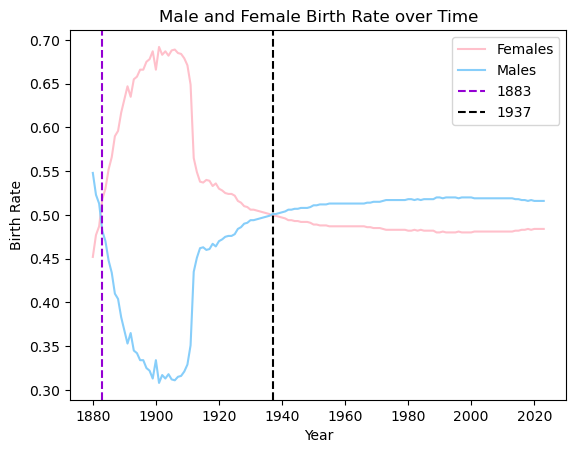

In [26]:
xtitle = 'Year'
ytitle = 'Birth Rate'
title = 'Male and Female Birth Rate over Time'

plt.xlabel(xtitle)
plt.ylabel(ytitle)
plt.title(title)
plt.plot(birth_percentages['year'], birth_percentages['female_br'], color = 'pink', label = 'Females')
plt.plot(birth_percentages['year'], birth_percentages['male_br'], color = 'lightskyblue', label = 'Males')
plt.axvline(x=1883, color='darkviolet', linestyle='--', label='1883') #Found via eda
plt.axvline(x=1937, color='black', linestyle='--', label='1937')
plt.legend();

Yeah, all this adds to a lot of interestng discussions, especially in years 1889 to 1911 that the female birthrate was over 20% that of males, maxing out at 69.2% to 30.8% in 1901.

Pragmatically recall I trend I remember from my actuarial days where apparently the expected age difference was that males would be 3 years older than females. So, on a population basis we might need to offset them by three, but eh...

In [31]:
# birth_percentages[birth_percentages['female_br']-birth_percentages['male_br']>.2]
# birth_percentages[birth_percentages['female_br']==birth_percentages['female_br'].max()]

In [22]:
#Re the unique names - I think it's better to contrast just two years than to do another line graph. I think it'll better
#emphasis the change over time.

#Hmm, should I be writing a formula for this? Eh, at least at the moment... So close to having that though when I have the years
#out in front.

y1 = 1880
y2 = 2023

y1_u_fnames, y1_u_mnames = df[(df['year']==y1)&(df['sex']=='F')].shape[0], df[(df['year']==y1)&(df['sex']!='F')].shape[0] #Perhaps should do count, but eh
y2_u_fnames, y2_u_mnames = df[(df['year']==y2)&(df['sex']=='F')].shape[0], df[(df['year']==y2)&(df['sex']!='F')].shape[0]

y1_avg_fname, y1_avg_mname = df[(df['year']==y1)&(df['sex']=='F')]['count'].mean(), df[(df['year']==y1)&(df['sex']!='F')]['count'].mean()
y2_avg_fname, y2_avg_mname = df[(df['year']==y2)&(df['sex']=='F')]['count'].mean(), df[(df['year']==y2)&(df['sex']!='F')]['count'].mean()

y1_females, y1_males = df[(df['year']==y1)&(df['sex']=='F')]['count'].sum(), df[(df['year']==y1)&(df['sex']!='F')]['count'].sum()
y2_females, y2_males = df[(df['year']==y2)&(df['sex']=='F')]['count'].sum(), df[(df['year']==y2)&(df['sex']!='F')]['count'].sum()

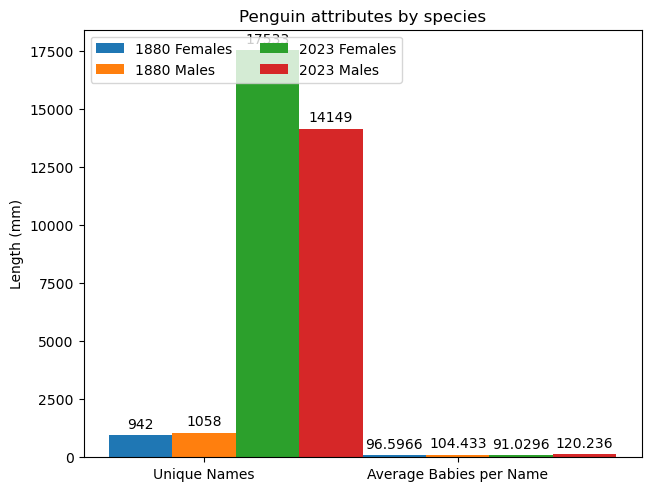

In [27]:
ytitle = 'Count'
title = 'Unique '

categories = ("Unique Names", "Average Babies per Name")
year_stats = {
    f'{y1} Females': (y1_u_fnames, y1_avg_fname),
    f'{y1} Males': (y1_u_mnames, y1_avg_mname),
    f'{y2} Females': (y2_u_fnames, y2_avg_fname),
    f'{y2} Males': (y2_u_mnames, y2_avg_mname)
}

x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in year_stats.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, categories)
ax.legend(loc='upper left', ncols=len(categories))
# ax.set_ylim(0, 250)

plt.show()

In [ ]:
#Future site for differenc in the populations.... I think we should make this graph part of th previous one, but as subplot below it

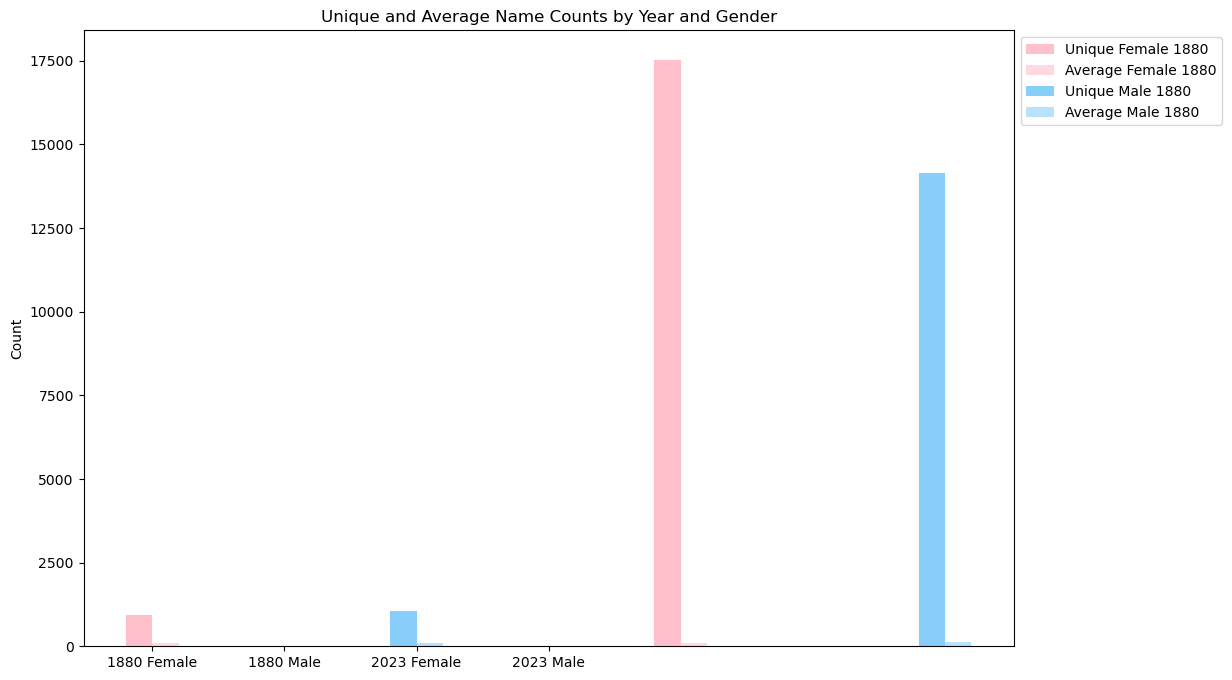

In [25]:
xtitle = 'Year'
ytitle = 'Birth Rate'
title = 'Male and Female Birth Rate over Time'

years = ['1880', '2023']
types = ['Unique Names', 'Average Babies per Name']
categories = ['Female', 'Male']
colors = ['pink', 'lightskyblue']

unique_names = [y1_u_fnames, y1_u_mnames, y2_u_fnames, y2_u_mnames]
avg_counts = [y1_avg_fname, y1_avg_mname, y2_avg_fname, y2_avg_mname]
# total_counts = [y1_females, y1_males, y2_females, y2_males]

data = [
    [y1_u_fnames, y1_avg_fname],
    [y1_u_mnames, y1_avg_mname],
    [y2_u_fnames, y2_avg_fname],
    [y2_u_mnames, y2_avg_mname]
]

# Bar positions
bar_width = 0.2
bar_positions = np.arange(len(years) * len(categories))

fig, ax = plt.subplots(figsize=(12, 8))

# Plot bars for each type (unique names and average count) for each category in each year
for i, (unique, avg) in enumerate(data):
    year_index = i // 2  # 0 for 1880, 1 for 2023
    category_index = i % 2  # 0 for Female, 1 for Male
    base_position = year_index * 4 + category_index * 2

    # Plot unique names
    ax.bar(base_position - bar_width / 2, unique, width=bar_width, color=colors[category_index], label=f'Unique {categories[category_index]} {years[year_index]}' if i < 2 else "")
    
    # Plot average count
    ax.bar(base_position + bar_width / 2, avg, width=bar_width, color=colors[category_index], alpha=0.6, label=f'Average {categories[category_index]} {years[year_index]}' if i < 2 else "")

# Set labels and title
ax.set_ylabel('Count')
ax.set_title('Unique and Average Name Counts by Year and Gender')
ax.set_xticks(bar_positions)
ax.set_xticklabels(['1880 Female', '1880 Male', '2023 Female', '2023 Male'])
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [14]:
df[(df['year']==1880)&(df['sex']=='F')]['count'].mean()

96.59660297239915

In [15]:
sum(df[(df['year']==1880)&(df['sex']=='F')]['count'])/y1_u_fnames

96.59660297239915

In [16]:
df[(df['year']==1880)&(df['sex']=='F')]['count'].count()

942

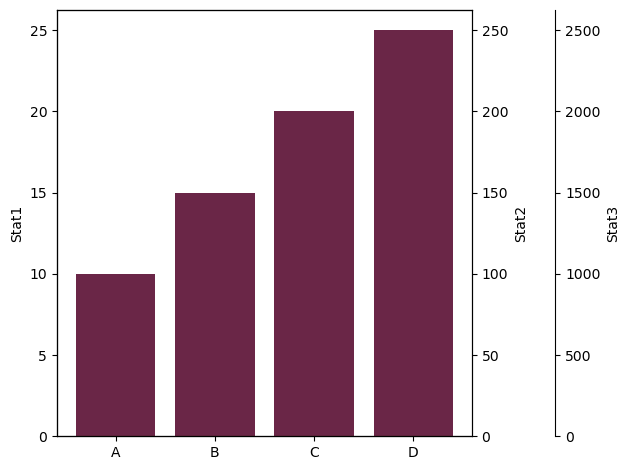

In [18]:
categories = ['A', 'B', 'C', 'D']
stat1 = [10, 15, 20, 25]
stat2 = [100, 150, 200, 250]
stat3 = [1000, 1500, 2000, 2500]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax3 = ax1.twinx()

# Offset the third axis
ax3.spines['right'].set_position(('outward', 60))

ax1.bar(categories, stat1, color='b', label='Stat1')
ax2.bar(categories, stat2, color='r', label='Stat2', alpha=0.6)
ax3.bar(categories, stat3, color='g', label='Stat3', alpha=0.3)

ax1.set_ylabel('Stat1')
ax2.set_ylabel('Stat2')
ax3.set_ylabel('Stat3')

fig.tight_layout()
plt.show()

In [33]:
df[(df['year']==2023)&(df['rank_of_year']<6)]

,first,sex,count,year,per_of_year,rank_of_year
2085537,Olivia,F,15270,2023,0.010,1
2085538,Emma,F,13527,2023,0.008,2
2085539,Charlotte,F,12596,2023,0.008,3
2085540,Amelia,F,12311,2023,0.008,4
2085541,Sophia,F,11944,2023,0.007,5
2103070,Liam,M,20802,2023,0.012,1
2103071,Noah,M,18995,2023,0.011,2
2103072,Oliver,M,14741,2023,0.009,3
2103073,James,M,11670,2023,0.007,4
2103074,Elijah,M,11452,2023,0.007,5


In [40]:
df[(df['year']==2023)&(df['first']=='Chad')]

,first,sex,count,year,per_of_year,rank_of_year
2104682,Chad,M,107,2023,0.0,1613
